## Data needed

- Theory:

> $C_{\ell}$ : theoretical power spectra from CAMB, values at each single $\ell$； (lensing BB + r + $\Lambda CDM$)

> $C_{\ell}^b$ : bandpower for each $\ell$-bin, using $W$indow function. 

> $**{C\ell_{th}}**$ = $ C\ell_\rm{CAMB} + N\ell$, theoretically, without realization

- Experiment(**Simulation**):

> $C_{f,l}$ : fiducial power spectra. From realizations of CMB and noise. 

> $W$ : window function for each $\ell$ bin；

> $M$ : band power covariance matrix; From realizations of Cf_l

> $N_{\ell}$ : noise;



- Data

> $\hat {C}_{\ell} $ : observed data.

BB 95 $\times$ 95 150 $\times$ 150 95 $\times$ 150

In [7]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import pymaster as nmt
import bandpowers
import utils
import camb
import numpy.linalg as LA

import imp
%matplotlib inline

In [9]:
## To generate one realization of noise maps. 
SamNum = 500

In [10]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

In [11]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nbin = len(leff)
b_ind = np.arange(1,nbin+1)

In [12]:
ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits', field = None)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [13]:
full_sky = np.ones(12*nside**2)

In [14]:
fres = ['95','150']; Nf = 2

## Generate Cl_theory ($C{\ell}_\rm{CMB}$) ;

In [15]:
def Gencl(r = 0.05, raw_cl = True):
    '''
    Generate the theoretical power spectra using camb
    '''
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
    pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r = r)
    pars.set_for_lmax(3000, lens_potential_accuracy=1)
    pars.WantTensors = True
    
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=raw_cl)
    
    totCL=powers['total'] ## TT EE BB TE
#     ell = np.arange(len(totCL.T[0]))
    return totCL.T

In [509]:
totalcl = Gencl(0.05, raw_cl=True);
totaldl = Gencl(0.05, raw_cl=False);

In [510]:
cl_th_i = b.bin_cell(totalcl[2][0:nmtlmax+1])  ## theoretical bandpower 

cl_th = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
for ell in range(lbin):
    cl_th[ell] *= cl_th_i[ell]

In [573]:
cl_th.shape

(10, 2, 2)

In [511]:
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy', cl_th)

## CMB

In [41]:
cl_r = Gencl(0.01, raw_cl=True)

In [42]:
for n in range(SamNum):
    
    cmb_map_i = hp.synfast(cl_r, nside = nside, new = True, verbose = False)
    
    np.save('/fnx/jianyao/Likelihood_data/Simulations/CMB/r_0p01/cmb_maps_mc_%03d.npy'%n, cmb_map_i)

In [28]:
total = np.zeros((Nf, 2, 12*nside**2)); 
cl_hat_r0_all = np.zeros((500, 3, est.lbin, Nf, Nf)) ## EE EB BB-mode 

cl_r0 = Gencl(0, raw_cl=True)

for n in range(500):
    
    cmb_r0 = hp.synfast(cl_r0, nside = nside, new = True, verbose = False)
    
    for fre in range(Nf):

        noise_i = np.load('/fnx/jianyao/Likelihood_data/Simulations/Noises_Ali_2fre/%sGHz/Noise_realizations_%sGHz_%03d.npy'%(fres[fre], fres[fre], 1))
           
        total[fre] = (cmb_r0 + noise_i + fore_maps[fre])[1:];  ## fore[fre] + ; only QU map for Jiaxin's code

    cl_hat_r0_all[n] = est.Cross_EB(total)## EE EB BB-mode

In [29]:
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/cl_hat_r0_all.npy', cl_hat_r0_all)

In [30]:
cl_hat_r0_all.shape

(500, 3, 10, 2, 2)

## Noise

> cl_noise_file = AliCPT_noise.dat

39x7 (first line is \ell bin, what remain are cross bandpowers bwtween frequencies)

cl_noise_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

In [978]:
# '/fnx/jianyao/Likelihood_data/ABSData/plkvar_30.fits',
# ,'/fnx/jianyao/Likelihood_data/ABSData/plkvar_353.fits'

nvars = ['/fnx/jianyao/Likelihood_data/ABSData/alivar_95.fits',
         '/fnx/jianyao/Likelihood_data/ABSData/alivar_150.fits']

In [530]:
sigma = np.ones(2)

sigma[0] = np.sum(hp.read_map(nvars[1], field = None, verbose = False)[1])/np.sum(ali_ma)  ## 95
sigma[1] = np.sum(hp.read_map(nvars[2], field = None, verbose = False)[1])/np.sum(ali_ma)  ## 150

In [568]:
sigma

array([0.04701521, 0.04701521])

In [979]:
Nf

2

### For full sky, 2fre

In [917]:
n2test = hp.read_map(nvars[2], field = None, verbose = False)
index = np.arange(len(n2test[0]))#index[n2zeros == 0]
ali_pix = index[n2test[1] != 0]

std = np.sqrt(sigma) 

for n in range(SamNum):
    
    for fre in range(Nf):

        nIQU = np.zeros((3, 12*nside**2))

        nIQU[0] = 0 #  , size = SamNum np.random.normal(0, 2.05) ## ignore TT noise for now.
        
        ## Q and U have the same noise level for now
        nIQU[1] = np.random.normal(0, std[fre], size = 12*nside**2)/10.0
        nIQU[2] = np.random.normal(0, std[fre], size = 12*nside**2)/10.0

        np.save('/fnx/jianyao/Likelihood_data/Simulations/Noises_2fre_fullsky_10_smaller/%sGHz/Noise_%sGHz_%03d.npy'%(fres[fre], fres[fre], n), nIQU) ## (SamNum,3, npix) , (nIQU.swapaxes(1,2).swapaxes(0,1))

In [915]:
fres

['95', '150']

### For Ali-sky, 4fre

In [980]:
# Nvar = np.concatenate((n1test, n2test, n3test, n4test), axis = 1)

n2test = hp.read_map(nvars[0], field = None, verbose = False)
index = np.arange(len(n2test[0]))#index[n2zeros == 0]
ali_pix = index[n2test[1] != 0]

fres = ['95','150']

for n in range(SamNum):
    
    for fre in range(Nf):

        var = np.sqrt(hp.read_map(nvars[fre], field = None, verbose = False))

        nIQU = np.zeros((3, 12*nside**2))

        for i in ali_pix:

            nIQU[0][i] = np.random.normal(0, var[0][i])  #  , size = SamNum np.random.normal(0, 2.05) ## ignore TT noise for now.
            nIQU[1][i] = np.random.normal(0, var[1][i])
            nIQU[2][i] = np.random.normal(0, var[2][i])

        np.save('/fnx/jianyao/Likelihood_data/Simulations/Noises_Ali_2fre/%sGHz/Noise_realizations_%sGHz_%03d.npy'%(fres[fre], fres[fre], n), nIQU) ## (SamNum,3, npix) , (nIQU.swapaxes(1,2).swapaxes(0,1))

## Foreground 

In [19]:
import Fg_template
imp.reload(Fg_template)

<module 'Fg_template' from '/home/jianyao/Likelihood/Fg_template.py'>

In [33]:
import pysm
from pysm.nominal import models
from pysm.common import convert_units

## import planck function 
from pysm.common import B as pf
from Fg_template import sync_ps, dust_ps

c30 = convert_units("uK_RJ", "uK_CMB", 30);
c95 = convert_units("uK_RJ", "uK_CMB", 95);
c150 = convert_units("uK_RJ", "uK_CMB", 150);

c353 = convert_units("uK_RJ", "uK_CMB", 353); 

In [21]:
sky_config = {'dust' : models("d1", nside), 'synchrotron' : models("s1", nside)}
sky = pysm.Sky(sky_config);

In [695]:
d95 = sky.dust(95)*c95; d150 = sky.dust(150)*c150;
d353 = sky.dust(353)*c353
s30 = sky.synchrotron(30)*c30

In [736]:
np.save('/fnx/jianyao/Likelihood_data/Simulations/Dust_353_maps.npy', d353)

In [606]:
hp.write_map('/fnx/jianyao/Likelihood_data/ABSData/dust_95GHz_128.fits', d95)
hp.write_map('/fnx/jianyao/Likelihood_data/ABSData/dust_150GHz_128.fits', d150)

In [620]:
## loading foreground and Noise

fore_names = ['/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_30.fits', '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_95.fits', 
              '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_150.fits', '/fnx/jianyao/Likelihood_data/ABSData/pysm_s1d1_353.fits' ]

dust = np.zeros((Nf, 3, 12*nside**2))

# for fre in range(Nf):
    
#     fore[fre] = hp.read_map(fore_names[fre], field = None);


dust[0] = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/dust_95GHz_128.fits', field=(0, 1, 2));
dust[1] = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/dust_150GHz_128.fits', field=(0, 1, 2));

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [15]:
s30_RJ = sky.synchrotron(30)
A_s = est.Auto_TEB(s30_RJ)[5]
sl = sync_ps(A_s, -3.0, 10)

np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy', sl)
# np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy', A_s)

d353_RJ = sky.dust(353)
A_d = est.Auto_TEB(d353_RJ)[5]
dust_dl = dust_ps(A_d, 1.56, 10)

# np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy', A_d)
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy', dust_dl)

### test foreground model

#### simple model

In [867]:
coeff = convert_units("uK_RJ", "uK_CMB", nu);

In [868]:
dust_all = sky.dust(nu)
A_d_all = np.ones((len(nu), 10))
for i in range(len(nu)):
    
    A_d_all[i] = est.Auto_TEB(dust_all[i])[5]*coeff[i]**2

In [873]:
sync_all = sky.synchrotron(nu)
A_s_all = np.ones((len(nu), 10))
for i in range(len(nu)):
    
    A_s_all[i] = est.Auto_TEB(sync_all[i])[5]*coeff[i]**2

- dust

- pixel space
$$I_{\nu} = (\nu/\nu_0)^{\beta_d} \frac{B(\nu, T)}{B(\nu_0, T)}$$

in **flux units**. Therefore $\beta_d$ ~ 1.54.

- harmonic space

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{d,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_d-2} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)} \frac{B_{\nu_2}(T_d)}{B_{\nu_0}(T_d)}$$

$$\left(\frac{\nu}{\nu_0}\right)^{{\beta_d}-2} \frac{B_\nu(T_d)}{B_{\nu_0}(T_d)} = \left( \frac{\nu}{\nu_0} \right)^{\beta_d+1} \frac{e^{h\nu_0/kT_d}-1}{e^{h\nu/kT_d}-1}$$

with Planck reference, we take $\nu_0=353$ GHz, $T_d = 19.6$ K.

$A_d$ — dust amplitude for each $\ell$, in $μK_{\rm RJ}^2$ , at 353 GHz, calculated from dust_353 map in $μK_{\rm RJ}$ units.

Output : $D_{\ell}$ in $μK_{\rm RJ}^2$, should be converted to $μK_{\rm CMB}^2$

- synchrotron

$$ \mathcal{D}^{XX}_\ell(\nu_1,\nu_2) = \mathcal{A}^{XX}_{s,\ell} \left( \frac{\nu_1 \nu_2}{\nu^2_0} \right)^{\beta_s} $$

with Planck reference, $\nu_0 = 30$ GHz.

$A_s$ — dust amplitude for each $\ell$, in $μK_{\rm RJ}^2$ , at 30 GHz, calculated from sync_30 map in $μK_{\rm RJ}$ units.
Output : $D_{\ell}$ in $μK_{\rm RJ}^2$, should be converted to $μK_{\rm CMB}^2$

In [986]:
nu = np.linspace(10,353,30)
dust_dl = dust_ps(A_d, 1.59, 10, nu = nu )
dust_dl_2 = dust_ps(A_d, 2.0, 10, nu = nu )

sync_dl = sync_ps(A_s, -3.0, 10, nu = nu)

In [1025]:
sync_dl_1 = sync_ps(A_s, -3.1, 10, nu = nu)
sync_dl_2 = sync_ps(A_s, -2.9, 10, nu = nu)

In [1020]:
dust_dl_3 = dust_ps(A_d, 1.558, 10, nu = nu )
dust_dl_4 = dust_ps(A_d, 1.52, 10, nu = nu )

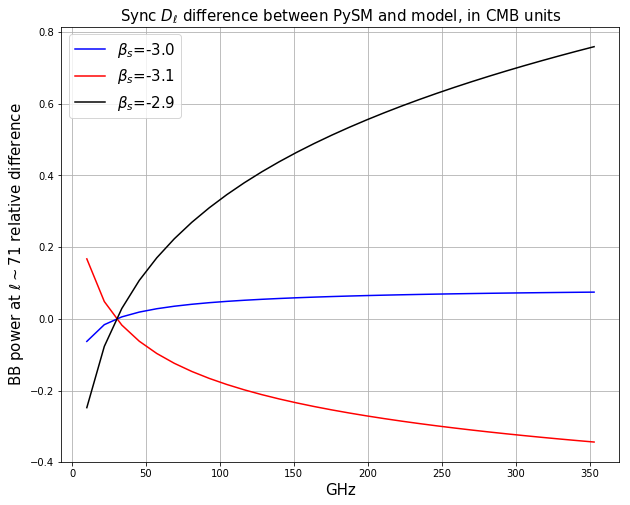

In [1038]:
plt.figure(figsize = (10,8))
# plt.plot(nu, np.diag(dust_dl[3]),'b-', label = r'model dust, $\beta_d$ = 1.59')
# # plt.plot(nu, np.diag(dust_dl_2[3]),'y-', label = r'model dust, $\beta_d$ = 2.0')
# plt.plot(nu, np.diag(dust_dl_3[3]),'r--', label = r'model dust, $\beta_d$ = 1.54')

# plt.plot(nu, np.diag(dust_dl_4[3]),'k--', label = r'model dust, $\beta_d$ = 1.52')


# plt.plot(nu, A_d_all[:,3], 'g-', label = 'PySM dust')

plt.plot(nu, (np.diag(sync_dl[3]) - A_s_all[:,3])/A_s_all[:,3],'b-', label = r'$\beta_s$=-3.0')
plt.plot(nu, (np.diag(sync_dl_1[3]) - A_s_all[:,3])/A_s_all[:,3],'r-', label = r'$\beta_s$=-3.1')
plt.plot(nu, (np.diag(sync_dl_2[3]) - A_s_all[:,3])/A_s_all[:,3],'k-', label = r'$\beta_s$=-2.9')


# plt.plot(nu, np.diag(sync_dl_23[3]),'y-', label = '23GHz model sync')
# plt.plot(nu, np.diag(sync_dl_408[3]),'y-', label = '408MHz model sync')
# plt.ylim(-0.01, 0.01)
plt.grid()

plt.xlabel('GHz', fontsize = 15); plt.ylabel(r'BB power at $\ell \sim 71$ relative difference', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Sync $D_{\ell}$ difference between PySM and model, in CMB units', fontsize = 15)
plt.savefig('./fig_results/PySM/Sync_dl.pdf', format = 'pdf')

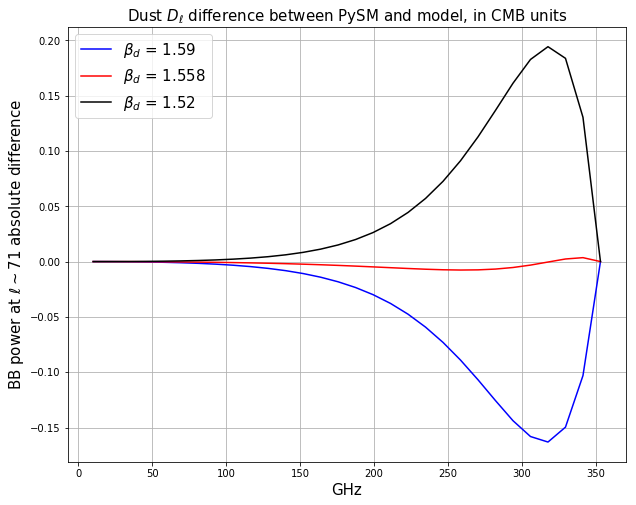

In [1040]:
plt.figure(figsize = (10,8))
plt.plot(nu, np.diag(dust_dl[3]) - A_d_all[:,3],'b-', label = r'$\beta_d$ = 1.59')
# plt.plot(nu, np.diag(dust_dl_2[3]),'y-', label = r'model dust, $\beta_d$ = 2.0')
plt.plot(nu, np.diag(dust_dl_3[3]) - A_d_all[:,3],'r-', label = r'$\beta_d$ = 1.558')

plt.plot(nu, np.diag(dust_dl_4[3]) - A_d_all[:,3],'k-', label = r'$\beta_d$ = 1.52')


plt.grid()
# plt.yscale('log')
plt.xlabel('GHz', fontsize = 15); plt.ylabel(r'BB power at $\ell \sim 71$ absolute difference', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Dust $D_{\ell}$ difference between PySM and model, in CMB units', fontsize = 15)
plt.savefig('./fig_results/PySM/Dust_dl.pdf', format = 'pdf')

In [837]:
from IPython.display import IFrame, display

In [8]:
IFrame('./Planck_foreground.png', width=800, height=550)

#### More complex model

$$\large{\mathcal{D}_{\ell, B B}^{\nu_{1} \times \nu_{2}}=A_{d u s t} \Delta_{\mathrm{d}}^{\prime} f_{\mathrm{d}}^{\nu_{1}} f_{\mathrm{d}}^{\nu_{2}}\left(\frac{\ell}{80}\right)^{\alpha_{\mathrm{d}}} +A_{\mathrm{sync}} \Delta_{\mathrm{s}}^{\prime} f_{\mathrm{s}}^{\nu_{1}} f_{\mathrm{s}}^{\nu_{2}}\left(\frac{\ell}{80}\right)^{\alpha_{\mathrm{s}}} \pm \epsilon \sqrt{A_{d u s t} A_{\mathrm{sync}}}\left(f_{\mathrm{d}}^{\nu_{1}} f_{\mathrm{s}}^{\nu_{2}}+f_{\mathrm{s}}^{\nu_{1}} f_{\mathrm{d}}^{\nu_{2}}\right)\left(\frac{\ell}{80}\right)^{\left(\alpha_{\mathrm{d}}+\alpha_{\mathrm{s}}\right) / 2}}$$

Typically constrain these 9 parameters:
1. ε — synchrotron–dust spatial correlation. A correlation parameter of 𝜖 = 1, corresponds to the spatial patterns of dust and synchrotron being the same, while 𝜖 = 0 results in completely independent patterns.
2. $A_d$ — dust amplitude, in $μK_{\rm RJ}^2$ , at 353 GHz and $\ell$ = 80.
3. $\beta_d$ — dust spectral index
4. $α_d$ — dust spatial spectral index
5. $Δ_d$ — dust frequency decorrelation. There is no decorrelation when Δ′ = 1 and complete decorrelation when Δ′ = 0.

6. $A_s$ — sync amplitude, in $μK_{\rm RJ}^2$ , at 23 GHz and $\ell$ = 80.
7. $β_s$ — sync spectral index
8. $α_s$ — sync spatial spectral index
9. $Δ_s$— sync frequency decorrelation


$$ \large{f_d^{\nu} = \left( \frac{\nu}{\nu_0} \right)^{\beta_d-2} \frac{B_{\nu_1}(T_d)}{B_{\nu_0}(T_d)}, \quad f_s^{\nu} = \left( \frac{\nu}{\nu_0} \right)^{\beta_s}}$$


$$\large{\Delta_{\mathrm{d}}^{\prime}\left(\nu_{1}, \nu_{2}, \ell\right)=\exp \left[\log \left(\Delta_{\mathrm{d}}\right) f\left(\nu_{1}, \nu_{2}\right) g(\ell)\right]}$$

$${\Delta_{\mathrm{d}}=\frac{\mathcal{D}_{80}(217 \times 353)}{\sqrt{\mathcal{D}_{80}(217 \times 217) \mathcal{D}_{80}(353 \times 353)}}}$$, 
$$f\left(\nu_{1}, \nu_{2}\right)=\frac{\left(\log \left(\nu_{1} / \nu_{2}\right)\right)^{2}}{(\log (217 / 353))^{2}}, \quad g(\ell)=\left\{\begin{array}{ll}
1 & \text { flat case } \\
(\ell / 80) & \text { linear case }
\end{array}\right.$$

We also consider dust and synchrotron frequency decorrelation. The simplest possible
model of a polarized foreground component is that with a fixed spatial pattern on the sky
which scales with frequency according to a single SED. In this case, the cross-spectrum between two frequencies is the geometric mean of the respective auto-spectra. In reality, the
polarization pattern inevitably varies as a function of frequency, leading to the cross-spectra
being suppressed with respect to the geometric mean of the auto-spectra. We refer to this phenomenon as decorrelation.

In [64]:
s30 = sky.synchrotron(30)*c30
A_s_CMB = est.Auto_TEB(s30)[5]
# sl = sync_ps(A_s, -3.0, 10)


d353 = sky.dust(353)*c353
A_d_CMB = est.Auto_TEB(d353)[5]
# dust_dl = dust_ps(A_d, 1.56, 10

##### $\Delta_d$

In [106]:
coeff_high = convert_units("uK_RJ", "uK_CMB", nu = np.array([217, 353]))

dust_high = sky.dust(nu = np.array([217, 353]))

dust_high[0] *= coeff_high[0]
dust_high[1] *= coeff_high[1]

In [113]:
dust_cross = est.Cross_EB(dust_high[:,1:, :])[2]

In [115]:
delta_d = dust_cross[3][0,1]/(np.sqrt(dust_cross[3][0,0]*dust_cross[3][1,1]))

In [116]:
delta_d

0.9995376376474717

In [119]:
def Delta_d(nu1, nu2, ell):
    
    f = np.log(nu1/nu2)**2/np.log(217/353)**2;
    g = ell/71.5; 
    
    return np.exp(np.log(delta_d)*f*g)

In [121]:
Delta_d(95, 150, est.ell_n)

array([0.99993445, 0.99982047, 0.9997065 , 0.99959255, 0.99947861,
       0.99936468, 0.99925076, 0.99913686, 0.99902297, 0.99890909])

In [122]:
Delta_d(150, 150, est.ell_n)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

##### comparision

In [87]:
alpha_s = -1.2; alpha_d = -0.4
sync_cl = A_s_CMB[3]*(est.ell_n/71.5)**alpha_s
dust_cl = A_d_CMB[3]*(est.ell_n/71.5)**alpha_d

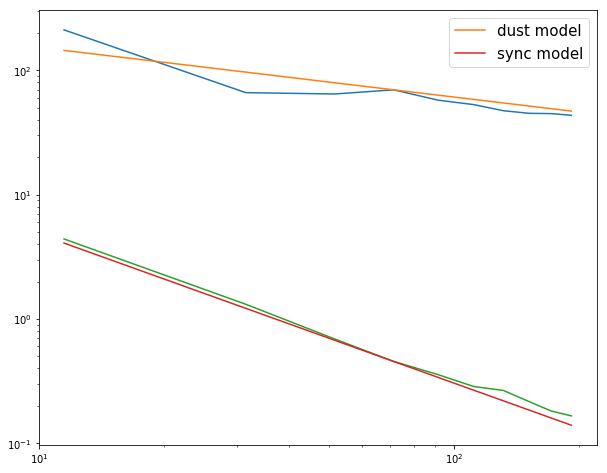

In [88]:
plt.figure(figsize = (10, 8))

plt.loglog(est.ell_n, A_d_CMB)
plt.loglog(est.ell_n, dust_cl, label = 'dust model')

plt.loglog(est.ell_n, A_s_CMB)
plt.loglog(est.ell_n, sync_cl, label = 'sync model')

plt.legend(fontsize = 15)

### D_l from PySM

In [22]:
nu = np.array((95, 150))
fore_maps = sky.signal()(nu)

fore_maps[0] *= c95;
fore_maps[1] *= c150

### Jiaxin's class

In [749]:
from fg_models import dustmodel

FREQS = list(np.linspace(30,353,20))
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 20
tmpmap = dict()
tmpmap[353] = d353[1:]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=ali_ma.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,templates=tmpmap)

In [758]:
d.reset({'beta_d':1.5})

In [771]:
d.bandpower().shape

(11, 20, 20)

Text(0.5, 0, 'GHz')

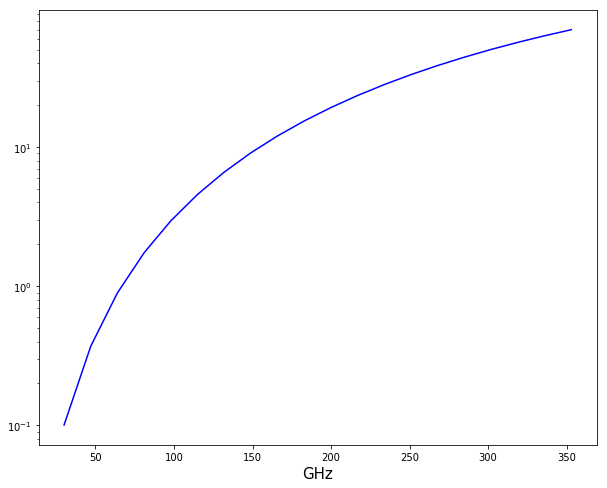

In [762]:
plt.figure(figsize = (10,8))
plt.plot(np.linspace(30,353,20), np.diag(d.bandpower()[2]), 'b-')
plt.yscale('log')
plt.xlabel('GHz', fontsize = 15)
# plt.legend(fontsize = 15)

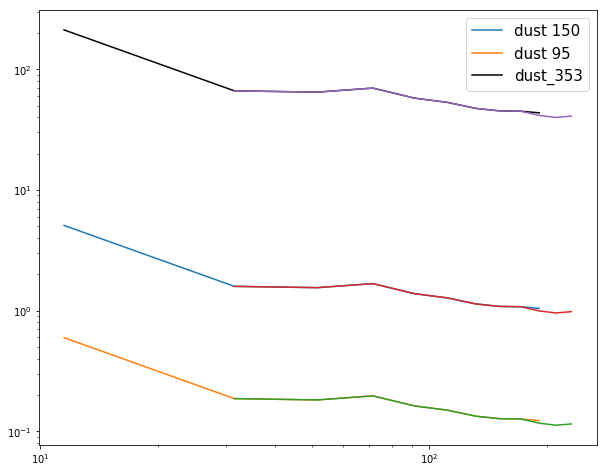

In [742]:
plt.figure(figsize = (10,8))


plt.loglog(est.ell_n, dust_dl[:,1,1], label = 'dust 150')
plt.loglog(est.ell_n, dust_dl[:,0,0], label = 'dust 95')
# plt.loglog(est.ell_n, dust_1_58[:,0,0], label = 'dust 30')
# plt.loglog(est.ell_n, A_d, label = 'dust 30')
plt.loglog(est.ell_n, A_d, 'k-', label = 'dust_353')
# plt.loglog(est.ell_n, dust_1_58[:,0,0], label = 'dust_1.58 95')


plt.loglog(d.modes,d.bandpower()[:,0,0])
plt.loglog(d.modes,d.bandpower()[:,1,1])
plt.loglog(d.modes,d.bandpower()[:,2,2])

plt.legend(fontsize = 15)

## Cl_fiducial ($C{\ell}_\rm{CMB}$ + N$\ell$) and Cl_hat ($C{\ell}_\rm{CMB}$ + N$\ell$ + Foreground)

In [636]:
imp.reload(bandpowers)

<module 'bandpowers' from '/home/jianyao/Likelihood/bandpowers.py'>

### calculate bandpowers

In [16]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = nmtlmax, wsp = True)
lbin = est.lbin

In [13]:
cl_f_all = np.ones((SamNum, 3, lbin, Nf, Nf));

cl_hat_all = np.zeros((SamNum, 3, est.lbin, Nf, Nf)) ## EE EB BB-mode 

nl_all = np.zeros((SamNum, 3, est.lbin, Nf, Nf))

In [923]:
cls_cmb = np.ones((SamNum, lbin))
for n in range(SamNum):
    ''' mark '''
    cmb_i_0p05 = np.load('/fnx/jianyao/Likelihood_data/Simulations/CMB/r_0p05/cmb_maps_mc_%03d.npy'%n)
    cls_cmb[n] = est.Auto_TEB(cmb_i_0p05)[5]
    
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/CMB_only_dl_ali.npy', cls_cmb)

In [45]:
SamNum

500

In [89]:
print('%03d'%4)

004


In [46]:
beam_low = 19; 

total = np.zeros((Nf, 2, 12*nside**2)); ### CMB plus Noise plus foreground.  

cpn = np.zeros((Nf, 2, 12*nside**2)); ## CMB plus noise

Noise = np.zeros((Nf, 2, 12*nside**2))

for n in range(SamNum):
    ''' mark '''
    cmb_i_0p01 = np.load('/fnx/jianyao/Likelihood_data/Simulations/CMB/r_0p01/cmb_maps_mc_%03d.npy'%n)
    
    ################ without beam first
    
    for fre in range(Nf):
        
        noise_i = np.load('/fnx/jianyao/Likelihood_data/Simulations/Noises_Ali_2fre/%sGHz/Noise_realizations_%sGHz_%03d.npy'%(fres[fre], fres[fre], n))
        
        ###Add Foreground FOR NOW, Then total == cpn  !!!!!!!!!!!!!!!!!!!!!!!!!! 2020.07.10             
#         total[fre] = (cmb_i_0p05 + noise_i + fore_maps[fre])[1:];  ## fore[fre] + ; only QU map for Jiaxin's code
        
        cpn[fre] = (cmb_i_0p01 + noise_i)[1:]
    
#         Noise[fre] = noise_i[1:]
        
#     cl_hat_all[n] = est.Cross_EB(total)## EE EB BB-mode
#     nl_all[n] = est.Cross_EB(Noise)
    cl_f_all[n] = est.Cross_EB(cpn)
    
    
    ################ considering beam
    ## should set in the Namaster
    
    #################

In [47]:
# np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/cl_hat_fore_all.npy', cl_hat_all)
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/cl_f_0p01_all.npy', cl_f_all)

In [984]:
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/nl_all.npy', nl_all)

In [1053]:
fl_pysm = est.Cross_EB(fore_maps[:,1:3,:])

In [1055]:
np.save('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/fl_pysm.npy', fl_pysm)

### each component

In [928]:
cl_mean = np.mean(cls_cmb, axis = 0)
nl_mean = np.mean(nl_all, axis = 0)

In [932]:
dust_ali = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p59_from_RJ.npy')
sync_ali = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p3_from_RJ.npy')

In [1042]:
nl_normal_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/nl_all.npy')
nl_normal = np.mean(nl_normal_all, axis = 0)

In [938]:
nl_normal.shape

(3, 10, 2, 2)

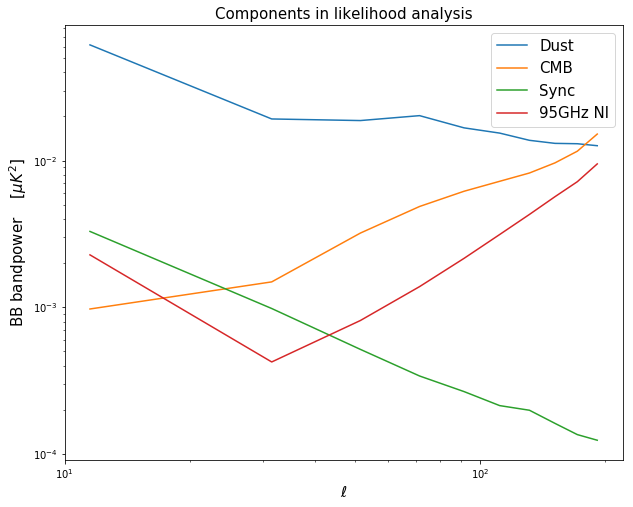

In [1047]:
plt.figure(figsize = (10,8))
plt.loglog(est.ell_n, dust_ali[:,0,0], label = 'Dust')
plt.loglog(est.ell_n, cl_mean, label = 'CMB')
plt.loglog(est.ell_n, sync_ali[:,0,0], label = 'Sync')

# plt.loglog(est.ell_n, nl_mean[2][:,0,0], label = '95GHz Nl s')
plt.loglog(est.ell_n, nl_normal[2][:,0,0], label = '95GHz Nl')

plt.xlabel(r'$\ell$', fontsize = 15); plt.ylabel(r'BB bandpower $\quad [\mu K^2]$', fontsize = 15)
plt.legend(fontsize = 15)
plt.title('Components in likelihood analysis', fontsize = 15)
plt.savefig('./fig_results/components.pdf', format = 'pdf')

## Calculate the correlation between different lbin

### calculate the bandpowers 

In [91]:
est = bandpowers.BPE(mask_in = ali_ma, nside = 128, bin_w = 20, lmax = nmtlmax, wsp = True)

In [ ]:
noise_150 = np.load('/fnx/jianyao/Likelihood_data/Simulations/Noises/Noise_realizations_150GHz.npy')

In [195]:
# cls_all = np.zeros((SamNum, 6, lbin)); 
cls_cmb = np.zeros((SamNum, 6, lbin)) 


for n in range(SamNum):
    ''' mark '''
    cmb_i = np.load('/fnx/jianyao/Likelihood_data/Simulations/CMB/cmb_maps_mc_%03d.npy'%n)
    
#     total_i = cmb_i + noise_150[n]
    
#     cls_all[n] = est.Auto_TEB(total_i)
    cls_cmb[n] = est.Auto_TEB(cmb_i)  ### TT TE TB EE EB BB
    
#     cl_hat_all[n] = est.Cross_EB(total_i)## EE EB BB-mode 

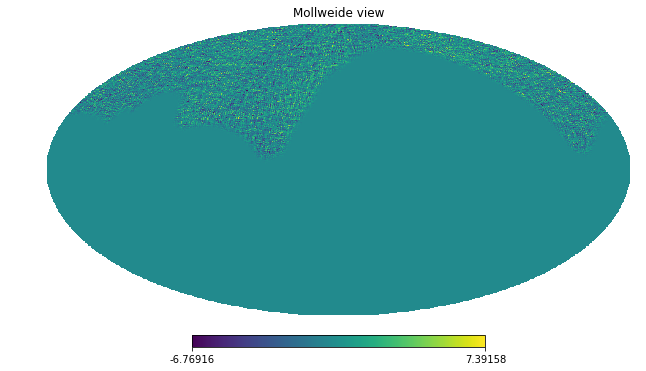

In [318]:
hp.mollview(cmb_i_apo[1])

In [ ]:
## cls_all = np.zeros((SamNum, 6, lbin)); 
cls_cmb_hp = np.zeros((SamNum, 6, nmtlmax+1));

cls_cmb_apo_hp = np.zeros((SamNum, 6, nmtlmax+1)) 


for n in range(SamNum):
    ''' mark '''
    
    cmb_i = np.load('/fnx/jianyao/Likelihood_data/Simulations/CMB/cmb_maps_mc_%03d.npy'%n)
    
    cmb_i_apo = cmb_i*mask ## apodized Ali mask
    cmb_i *= ali_ma ## apply Ali mask
    
    cls_cmb_hp[n] = hp.anafast(cmb_i, lmax = nmtlmax)   ### TT, EE, BB, TE, EB, TB
    cls_cmb_apo_hp[n] = hp.anafast(cmb_i_apo, lmax = nmtlmax)
    
##    cl_hat_all[n] = est.Cross_EB(total_i)
##    EE EB BB-mode 

In [325]:
cls_cmb_hp_mean = np.mean(cls_cmb_hp, axis = 0)
cls_cmb_hpapo_mean = np.mean(cls_cmb_apo_hp, axis = 0)

bb_hpapo = b.bin_cell(cls_cmb_hpapo_mean[2])
bb_hp = b.bin_cell(cls_cmb_hp_mean[2])

In [345]:
fsky = sum(ali_ma)/(12*nside**2)
fsky_apo = sum(mask)/(12*nside**2)

In [309]:
el2 = utils.l2(est.ell_n)

In [254]:
bb_master = np.mean(cls_cmb, axis = 0)[5]

In [441]:
ee_master = np.mean(cls_cmb, axis = 0)[3]

In [426]:
bb_std = np.std(cls_cmb, axis = 0)[5]

In [368]:
eb_master = np.mean(cls_cmb, axis = 0)[4] ### TT TE TB EE EB BB
eb_hp = b.bin_cell(cls_cmb_hp_mean[4]) ### TT, EE, BB, TE, EB, TB

In [432]:
eb_std = np.std(cls_cmb, axis = 0)[4]

In [451]:
ratio = np.sqrt(bb_master*ee_master)

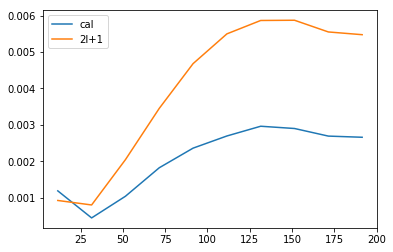

In [454]:
plt.plot(est.ell_n, eb_std, label = 'cal')
plt.plot(est.ell_n, ratio/ np.sqrt((est.ell_n*2 + 1)), label = '2l+1')
plt.legend()

In [443]:
eb_master + bb_master*ee_master

array([-2.80272529e-05,  7.95295249e-05,  4.37218333e-04,  1.62834023e-03,
        4.09073576e-03,  6.94153280e-03,  9.09332171e-03,  1.03807858e-02,
        1.06573415e-02,  1.15144210e-02])

In [421]:
tb_master = np.mean(cls_cmb, axis = 0)[2] ### TT TE TB EE EB BB
tb_hp = b.bin_cell(cls_cmb_hp_mean[5]) ### TT, EE, BB, TE, EB, TB

In [428]:
tb_std = np.std(cls_cmb, axis = 0)[2]

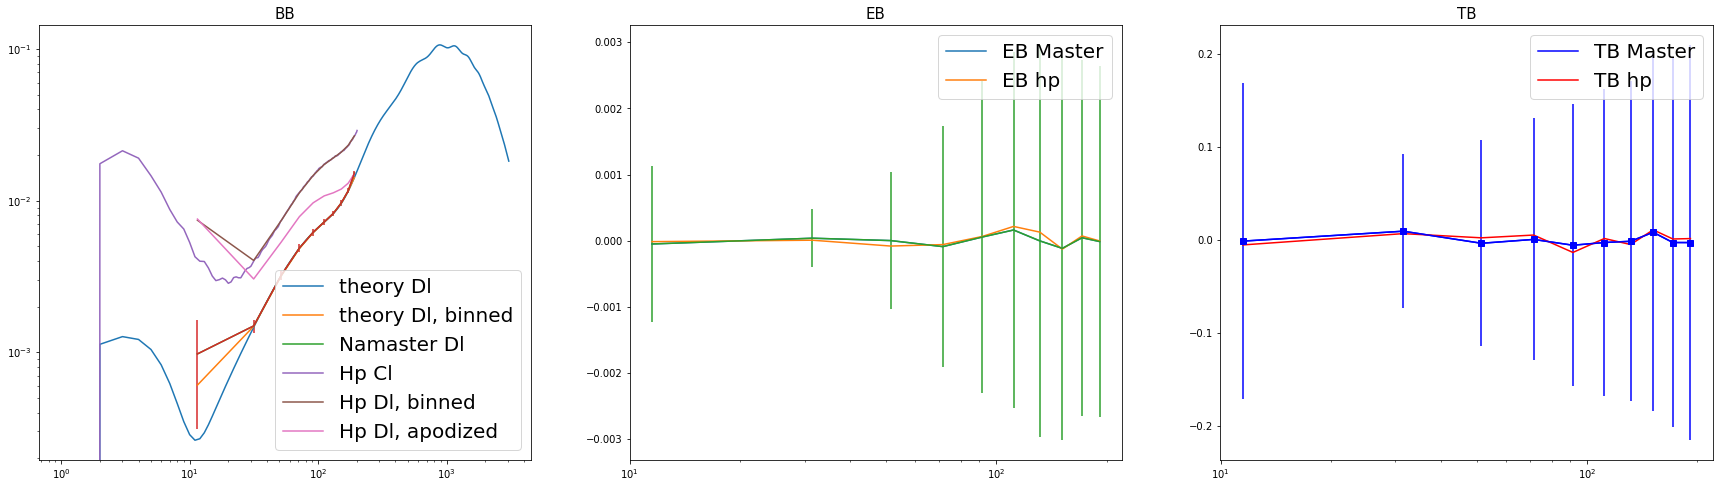

In [465]:
fig, ax = plt.subplots(1,3,figsize = (30, 8))
ax[0].set_title('BB', fontsize = 15)
ax[0].loglog(totaldl[2], label = 'theory Dl')

ax[0].loglog(est.ell_n,cl_th_i, label = 'theory Dl, binned' )
ax[0].loglog(est.ell_n, bb_master, label = 'Namaster Dl')
ax[0].errorbar(est.ell_n,bb_master, bb_std)

ll = np.arange(len(cls_cmb_hp_mean[0]))

ax[0].loglog(ll, utils.l2(ll)*cls_cmb_hp_mean[2]/fsky, label = 'Hp Cl')
# plt.loglog(ll, utils.l2(ll)*totalcl[2][0:202])

ax[0].loglog(est.ell_n, bb_hp/fsky, label = 'Hp Dl, binned')
ax[0].loglog(est.ell_n, bb_hpapo/fsky_apo, label = 'Hp Dl, apodized')

ax[0].legend(fontsize = 20)

ax[1].set_title('EB', fontsize = 15)
ax[1].plot(est.ell_n,(eb_master), label = 'EB Master')
ax[1].plot(est.ell_n,(eb_hp)/fsky, label = 'EB hp')
ax[1].errorbar(est.ell_n, (eb_master), eb_std)
ax[1].legend(fontsize = 20)
ax[1].set_xscale('log')

ax[2].set_title('TB', fontsize = 15)
ax[2].plot(est.ell_n,(tb_master), label = 'TB Master', color = 'b')
ax[2].errorbar(est.ell_n, (tb_master), tb_std, marker='s',color = 'b')

ax[2].plot(est.ell_n,(tb_hp)/fsky, label = 'TB hp', color = 'r')
ax[2].legend(fontsize = 20)
ax[2].set_xscale('log')
fig.savefig('./fig_results/PS_from_Namaster_and_Healpy.pdf', format = 'pdf')

In [197]:
cov_cmb = np.zeros((6, 10, 10))

for i in range(6):
    
    cov_cmb[i] = np.corrcoef(cls_cmb[:,i,:].T)

In [413]:
cls_cmb_hp.shape

(500, 6, 202)

In [415]:
cls_cmb_hp_binned = np.zeros((SamNum, 6, 10))

for n in range(SamNum):
    
    for i in range(6):

        cls_cmb_hp_binned[n, i] = b.bin_cell(cls_cmb_hp[n, i])



cov_cmb_hp = np.zeros((6, 10, 10))

for i in range(6):
    
    cov_cmb_hp[i] = np.corrcoef(cls_cmb_hp_binned[:,i,:].T)

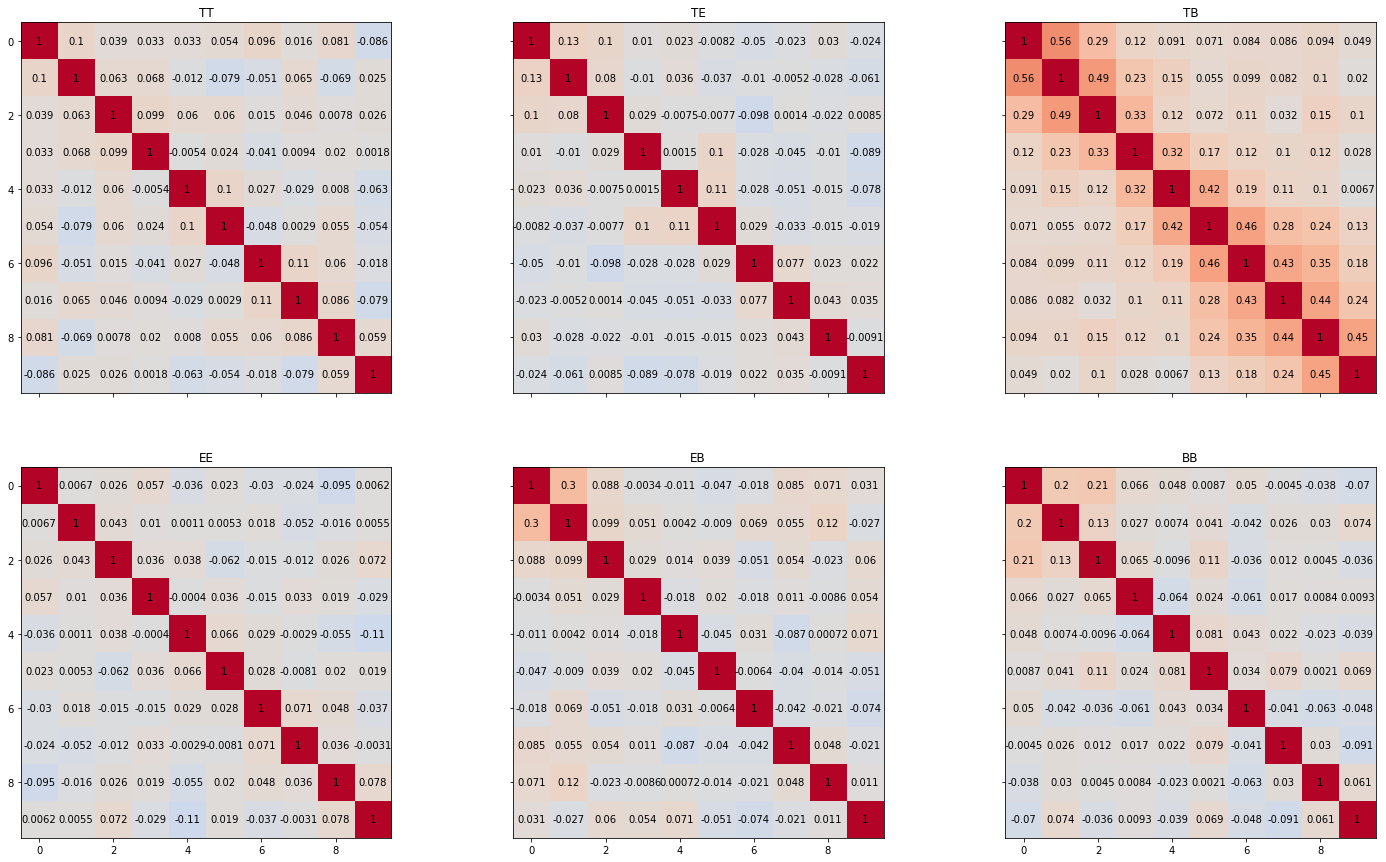

In [420]:
### healpy results

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize = (25,15)); mode_name = ['TT', 'TE', 'TB', 'EE', 'EB', 'BB']
# plt.title('CMB only')
for i in range(6):
    m = i//3; n = i%3
    
    cl = ax[m,n].imshow(cov_cmb_hp[i], cmap = "coolwarm", vmin = -1, vmax = 1)
    ax[m,n].set_title('%s'%mode_name[i])
    
    for j in range(10):
        for k in range(10):
            text = ax[m,n].text(j, k, '%.2g'%cov_cmb[i][j, k],
                       ha="center", va="center", color="k")
            
fig.savefig('./fig_results/Healpy_Correlation_ell_CMB_only.pdf', format = 'pdf')

In [153]:
cov_all = np.zeros((6, 10, 10))

for i in range(6):
    
    cov_all[i] = np.corrcoef(cls_all[:,i,:].T)

In [170]:
print('%.2g'%12.3)

12


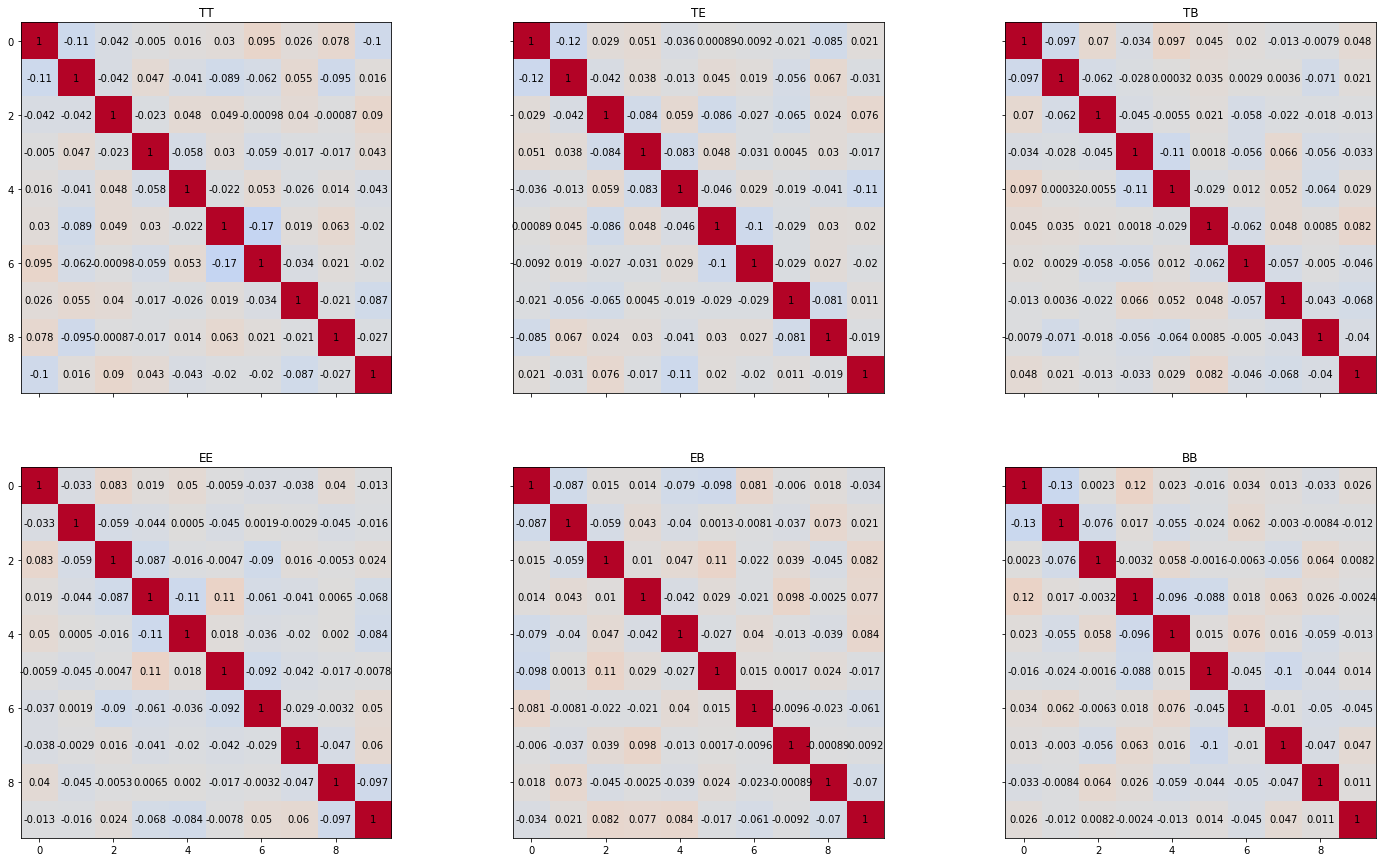

In [379]:
### CMB only

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize = (25,15)); mode_name = ['TT', 'TE', 'TB', 'EE', 'EB', 'BB']
# plt.title('CMB only')
for i in range(6):
    m = i//3; n = i%3
    
    cl = ax[m,n].imshow(cov_cmb[i], cmap = "coolwarm", vmin = -1, vmax = 1)
    ax[m,n].set_title('%s'%mode_name[i])
    
    for j in range(10):
        for k in range(10):
            text = ax[m,n].text(j, k, '%.2g'%cov_cmb[i][j, k],
                       ha="center", va="center", color="k")
            
fig.savefig('./fig_results/Correlation_ell_CMB_only.pdf', format = 'pdf')

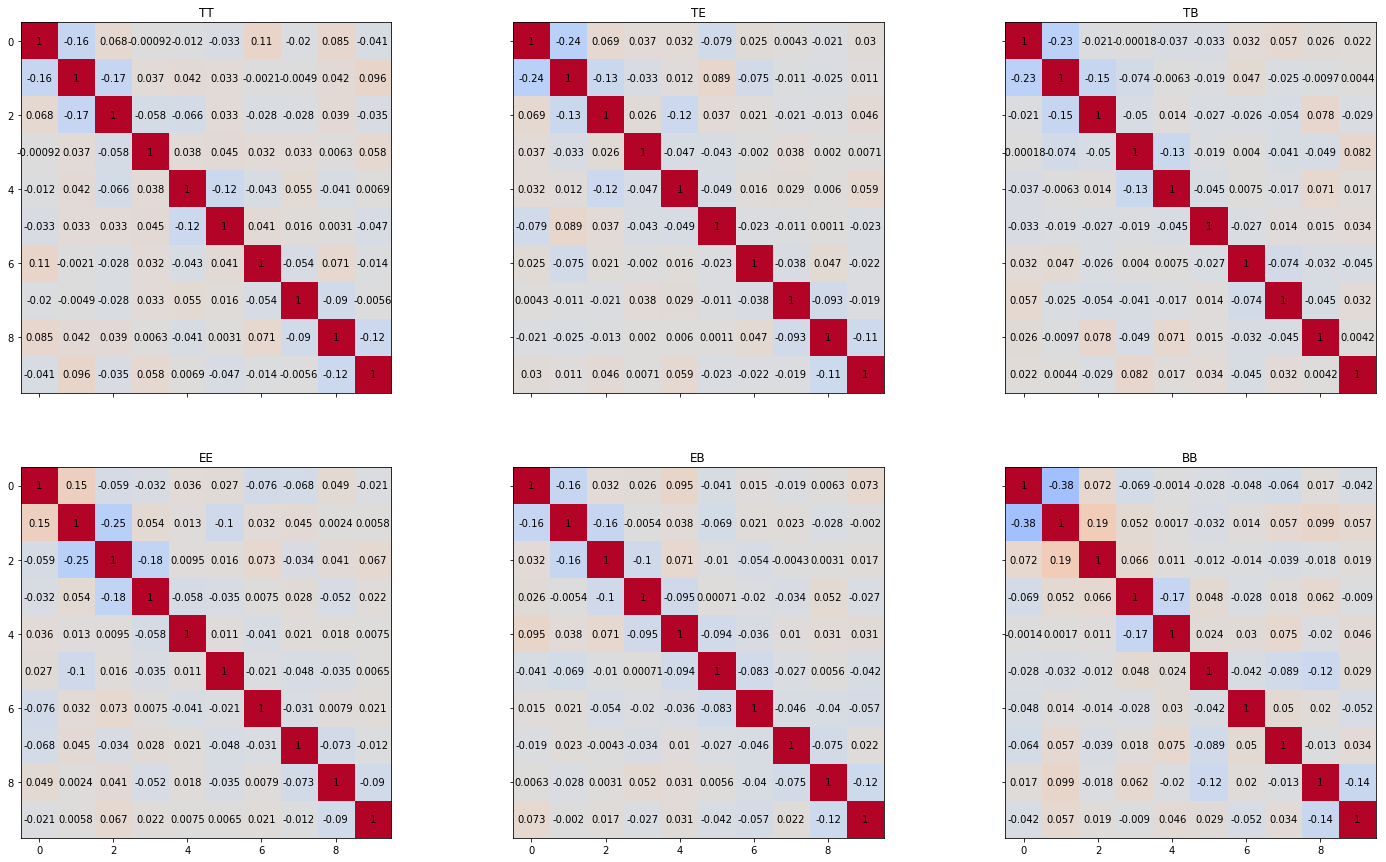

In [378]:
### CMB + noise

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize = (25,15)); mode_name = ['TT', 'TE', 'TB', 'EE', 'EB', 'BB']
for i in range(6):
    m = i//3; n = i%3
    
    cl = ax[m,n].imshow(cov_all[i], cmap = 'coolwarm', vmin = -1, vmax = 1)
    ax[m,n].set_title('%s'%mode_name[i])
    
    for j in range(10):
        for k in range(10):
            text = ax[m,n].text(j, k, '%.2g'%cov_all[i][j, k],
                       ha="center", va="center", color="k")
# fig.tight_layout()
# plt.colorbar(cl)
fig.savefig('./fig_results/Correlation_ell_CMB+Noise.pdf', format = 'pdf')

In [144]:
# 

# 

## Generate M